# Intra-Cluster Light (ICL) profiles analysis in the Dark Energy Survey (DES)

## Lupton Magnitudes

https://iopscience.iop.org/article/10.1086/301004

https://arxiv.org/pdf/astro-ph/9903081.pdf

In [1]:
import healpy as hp
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from healpy.rotator import Rotator
import kmeans_radec
from kmeans_radec import KMeans, kmeans_sample
import os
import os.path
import configparser
import sys
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

/home/hillysson/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [7]:
ini_file= 'redmapper_y1.ini'
config = configparser.ConfigParser()
inifile = config.read(ini_file)
input_dir_rdmp=config.get('input', 'input_dir')
catalog=config.get('input', 'catalog_file')
flag_files_rdmp=[ii.strip() for ii in config.get('input', 'flag_files').split(',')]
save_dir_rdmp=config.get('output', 'save_dir')
grid_output_dir_rdmp=config.get('grid_output', 'save_dir')
rdmp=pyfits.open(catalog)[1].data
flags_rdmp=np.zeros(len(rdmp))+1
indices_rdmp=np.arange(len(rdmp))

str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             r'$\lambda$ = [60;$\infty$)']
richness_dir = ['richness_20_30/',
                'richness_30_45/',
                'richness_45_60/',
                'richness_60_beyond/']

# getting indices in the flag files
for file_flag in flag_files_rdmp:
    if os.path.isfile(file_flag):
        flag_dat=np.loadtxt(file_flag, dtype=[('index', int), ('flag', int)], skiprows=1)
        flag=flag_dat['flag']
        if len(flag) == len(flags_rdmp):
            flags_rdmp=flags_rdmp*flag

ind1, =np.where( (flags_rdmp > 0.5) & (flags_rdmp<1.5) & (rdmp['lambda_chisq']>= 20) & (rdmp['lambda_chisq'] < 30))
print(len(ind1), len(indices_rdmp))
ind2, =np.where( (flags_rdmp > 0.5) & (flags_rdmp<1.5) & (rdmp['lambda_chisq']>= 30) & (rdmp['lambda_chisq'] < 45))
print(len(ind2), len(indices_rdmp))
ind3, =np.where( (flags_rdmp > 0.5) & (flags_rdmp<1.5) & (rdmp['lambda_chisq']>= 45) & (rdmp['lambda_chisq'] < 60))
print(len(ind3), len(indices_rdmp))
ind4, =np.where( (flags_rdmp > 0.5) & (flags_rdmp<1.5) & (rdmp['lambda_chisq']>= 60) & (rdmp['lambda_chisq'] < 40000000))
print(len(ind4), len(indices_rdmp))


lambdamean = [np.mean(rdmp['lambda_chisq'][ind1]), 
                  np.mean(rdmp['lambda_chisq'][ind2]), 
                  np.mean(rdmp['lambda_chisq'][ind3]),
                  np.mean(rdmp['lambda_chisq'][ind4])]  
lambdamean

307 7066
152 7066
52 7066
32 7066


[24.061209, 35.77201, 50.39139, 81.282715]

In [8]:
def rm_mrr(Lambda): #McClintock relation
    X_piv, z_piv = 40., 0.35
    A0, B0, C0, Z0 = 14.489,  1.356, -0.30, 0.275
    return (10.**A0) * ((Lambda/ X_piv)**B0)  * (((1+Z0) / (1+z_piv)) **(C0))
def criticaldens(z): # Critical density function  
    from astropy import units as u
    SolarM = u.Msun # solar masses
    kpc3 = u.kpc * u.kpc * u.kpc # Mpc^3
    Conv_factor = SolarM / kpc3
    rhoc_ = cosmo.critical_density(z)
    rhoc = rhoc_.to(Conv_factor)
    return rhoc

In [9]:
str_ngals = ['$\lambda$ = [20;30)',
             '$\lambda$ = [30;45)',
             '$\lambda$ = [45;60)',
             '$\lambda$ = [60;150)']
richness_dir = ['richness_20_30/',
                'richness_30_45/',
                'richness_45_60/',
                'richness_60_beyond/']

numflag = 0
flag = ['', '_scaled'][numflag]
flag

''

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


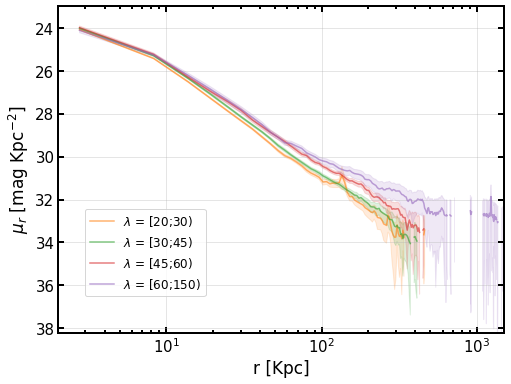

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log10


52.57 Kpc
262.84 Kpc
 
62.89 Kpc
314.44 Kpc
 
73.42 Kpc
367.12 Kpc
 
91.14 Kpc
455.68 Kpc
 


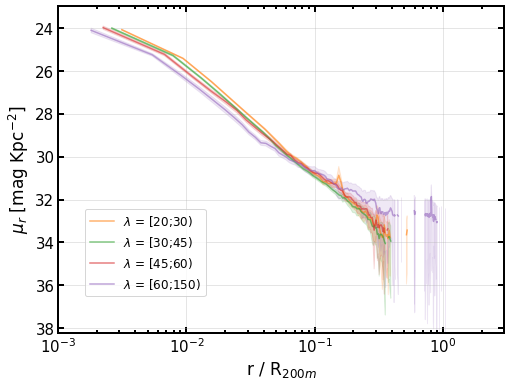

In [11]:
fig = plt.figure(figsize=(8,6))  
ax = plt.subplot()
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C1','C2','C3','C4']



for i in range(4):  
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;150)']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments%s.fits'%(flag))
    r_red, mea, std, mag_unc = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2], jacknife_profile.T[3]

    #yyfactor=1.0/(cosmo.kpc_proper_per_arcmin(0.275).value/60)**2
    #mea = mea_/yyfactor
    #std = std_/yyfactor
    
    up = mea+std
    low = mea-std
    
    mag = 30 - 2.5 * np.log10(mea)
    mag_up = 30 - 2.5 *np.log10(up)
    mag_low = 30 - 2.5 * np.log10(low)
    
    n_mag = []
    for l in range(359):
        if str(mag_low[l])=='nan':
            n_mag.append(mag_low[l])
        else:
            n_mag.append(mag[l])
    
    #var_mag_unc = ( (a)**2 * (sigma_)**2 ) / ( 4*(b_)**2 + (f0)**2) 
    #mag_unc = np.sqrt( var_mag_unc )
            
    plt.plot(r_red, n_mag, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, mag_up, mag_low, color=colors[i], alpha=0.15, label='')

plt.ylabel('$\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=17)

plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylim(38.2,23)
plt.xlim(2,1500)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)
    
plt.legend(bbox_to_anchor=(0.06, 0.38), loc=2, fontsize=12,borderaxespad=0.,numpoints=1,scatterpoints=1)

plt.show()
##############################################################################



fig = plt.figure(figsize=(8,6))  
ax = plt.subplot()
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C1','C2','C3','C4']

for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;150)']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments%s.fits'%(flag))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

    up = mea+std
    low = mea-std
    
    mag = 30 - 2.5 * np.log10(mea)
    mag_up = 30 - 2.5 *np.log10(up)
    mag_low = 30 - 2.5 * np.log10(low)

    
    # clusters: m200 and r200
    #lambdamean = [24.061209, 35.77201, 50.39139, 81.282715]
    lambda_= lambdamean[i]
    m200m = rm_mrr(np.array(lambda_))  
    rhoc = criticaldens(0.275)        
    rhoc_prop = rhoc  #* (cosmo.h**2)
    rhom = cosmo.Om0 * rhoc_prop * (1 + 0.275)**3
    r200m = np.cbrt( (3.*m200m) / (2000.*np.pi*rhom) )  
    
    
    print('%.2f Kpc'%(r200m*0.06).value)
    print('%.2f Kpc'%(r200m*0.3).value)
    print(' ')
    
    
    n_mag = []
    for l in range(359):
        if str(mag_low[l])=='nan':
            n_mag.append(mag_low[l])
        else:
            n_mag.append(mag[l])
    #var_mag_unc = ( (a)**2 * (sigma_)**2 ) / ( 4*(b_)**2 * (f0)**2) 
    #mag_unc = np.sqrt( var_mag_unc )   
    
    plt.plot(r_red/r200m, n_mag, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red/r200m, mag_up, mag_low, color=colors[i], alpha=0.15, label='')
    

plt.ylabel('$\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)

plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylim(38.2,23)
plt.xlim(0.001,3)
plt.xlabel('r / R$_{200m}$', fontsize=17)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)
    
plt.legend(bbox_to_anchor=(0.06, 0.38), loc=2, fontsize=12,borderaxespad=0.,numpoints=1,scatterpoints=1)

plt.savefig(save_dir_rdmp+'paper_figures/'+'scaled_iclprofiles.png', format='png', dpi=300)
plt.show()
##############################################################################

In [6]:
def luptonmags(flux, sigma_):
    ##########################
    ## computing luptitudes ##
    ##########################
    
    m0 = 30.
    f0 = 10.**(m0/2.5)

    a =  2.5*np.log10(np.e) #1.08574
    sigma = sigma_/f0
    b = np.sqrt(a)*sigma
    b_ = f0 * b

    x = flux/f0 

    #mu = (m0 - 2.5 * np.log10(b_)) - a * np.arcsinh(flux/ (2.*b_) )
    mu0 = (m0 - 2.5 * np.log10(b_)) - a * np.arcsinh(0/ (2.*b_) ) # for this eq. flux=0.
    mu = mu0 - a * np.arcsinh(flux/ (2.*b_) ) 
        
    var_mag_unc = ( (a)**2 * (sigma_)**2 ) / ( 4*(b_)**2 + (flux)**2) 
    mag_unc = np.sqrt( var_mag_unc )
    
    return mu, mag_unc
#mu, mag_unc = luptonmags(mea, std)

/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


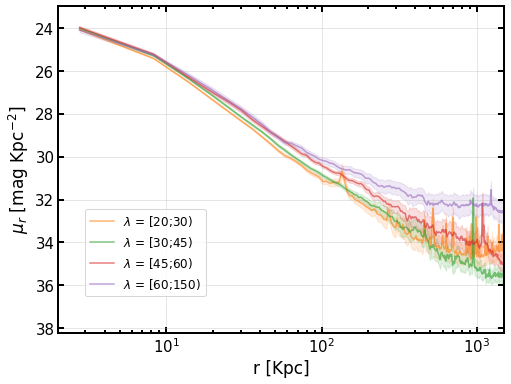

In [7]:
fig = plt.figure(figsize=(8,6))  
ax = plt.subplot()
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C1','C2','C3','C4']

for i in range(4):  
    
   
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;150)']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments%s.fits'%(flag))
    r_red, mea, std, mag_unc = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2], jacknife_profile.T[3]

    mu, mag_unc = luptonmags(mea, std)

    plt.plot(r_red, mu, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, mu + mag_unc, mu - mag_unc, color=colors[i], alpha=0.15, label='')
    
plt.ylabel('$\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=17)

plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylim(38.2,23)
plt.xlim(2,1500)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)

plt.legend(bbox_to_anchor=(0.06, 0.38), loc=2, fontsize=12,borderaxespad=0.,numpoints=1,scatterpoints=1)

plt.savefig(save_dir_rdmp+'paper_figures/'+'iclprofiles_lup.png', format='png', dpi=300)
plt.show()
##############################################################################

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packag

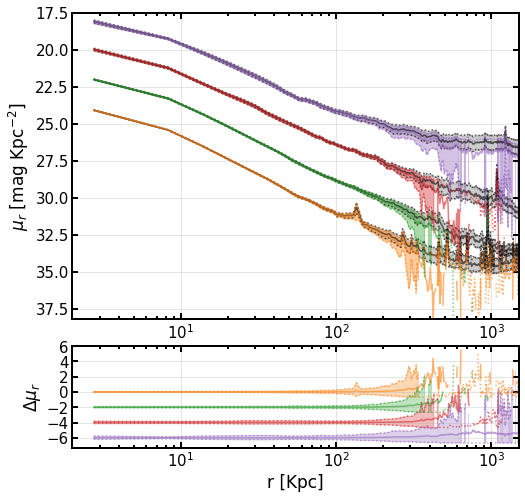

In [8]:
from matplotlib import gridspec
fig = plt.figure(figsize=(8,8))  
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C1','C2','C3','C4']
colorss = ['black','black','black','black']
lines = ['-','-','-','-']
liness = [':',':',':',':']
aa=0

for i in range(4):  
    
   
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;150)']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments%s.fits'%(flag))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
 
    mu, mag_unc = luptonmags(mea, std)
   
    plt.plot(r_red, -aa+mu, lines[i], lw=1.5,alpha=0.6,color=colorss[i],label=str_ngals[i])
    plt.plot(r_red, -aa+mu+ mag_unc, liness[i], lw=1.5,alpha=0.6,color=colorss[i],label=str_ngals[i])
    plt.plot(r_red, -aa+mu- mag_unc, liness[i], lw=1.5,alpha=0.6,color=colorss[i],label=str_ngals[i])
    plt.fill_between(r_red, -aa+mu + mag_unc, -aa+mu - mag_unc, color=colorss[i], alpha=0.2, label='')
    
    
    
    up = mea+std
    low = mea-std
    
    mag = 30 - 2.5 * np.log10(mea)
    mag_up = 30 - 2.5 *np.log10(up)
    mag_low = 30 - 2.5 * np.log10(low)
    
    plt.plot(r_red, -aa+mag, lines[i], lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.plot(r_red, -aa+mag_up, liness[i], lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.plot(r_red, -aa+mag_low, liness[i], lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, -aa+mag_up, -aa+mag_low, color=colors[i], alpha=0.4, label='')
    
    aa = aa+2
    
plt.ylabel('$\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=0)

plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylim(38.2,17.5)
plt.xlim(2,1500)
[ax1.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0.13)

#plt.legend(bbox_to_anchor=(0.06, 0.38), loc=2, fontsize=12,borderaxespad=0.,numpoints=1,scatterpoints=1)





ax2 = plt.subplot(gs[1],sharex=ax1)
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C1','C2','C3','C4']
aa=0

for i in range(4):  
    
   
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;150)']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments%s.fits'%(flag))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
 
    up = mea+std
    low = mea-std

    mag = 30 - 2.5 * np.log10(mea)
    mag_up = 30 - 2.5 *np.log10(up)
    mag_low = 30 - 2.5 * np.log10(low)

    mu, mag_unc = luptonmags(mea, std)

    plt.plot(r_red, -aa+mag - mu, lines[i], lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, -aa+mag_up - (mu + mag_unc), -aa+mag_low - (mu - mag_unc), color=colors[i], 
                     alpha=0.3, label='')
    plt.plot(r_red, -aa+mag_up - (mu + mag_unc), liness[i], lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.plot(r_red, -aa+mag_low - (mu - mag_unc), liness[i], lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    aa = aa+2

plt.ylabel('$\Delta\mu_{r}$', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=17)

plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#plt.ylim(38.2,23)
plt.xlim(2,1500)
[ax2.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]

#plt.legend(bbox_to_anchor=(0.06, 0.38), loc=2, fontsize=12,borderaxespad=0.,numpoints=1,scatterpoints=1)


plt.savefig(save_dir_rdmp+'paper_figures/'+'iclprofiles_lup_comparison.png', format='png', dpi=300)
plt.show()
##############################################################################

52.57 Kpc
262.84 Kpc
 
62.89 Kpc
314.44 Kpc
 
73.42 Kpc
367.12 Kpc
 
91.14 Kpc
455.68 Kpc
 


/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


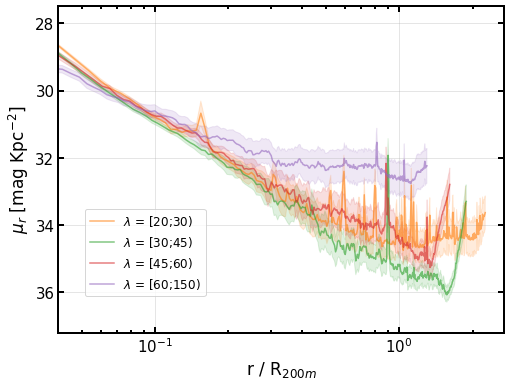

In [9]:
fig = plt.figure(figsize=(8,6))  
ax = plt.subplot()
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C1','C2','C3','C4']

for i in range(4):
    
    
    
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;150)']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments%s.fits'%(flag))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]

    
    # clusters: m200 and r200
    lambdamean = [24.061209, 35.77201, 50.39139, 81.282715]
    lambda_= lambdamean[i]
    m200m = rm_mrr(np.array(lambda_))  
    rhoc = criticaldens(0.275)        
    rhoc_prop = rhoc  #* (cosmo.h**2)
    rhom = cosmo.Om0 * rhoc_prop * (1 + 0.275)**3
    r200m = np.cbrt( (3.*m200m) / (2000.*np.pi*rhom) )  
    
    
    print('%.2f Kpc'%(r200m*0.06).value)
    print('%.2f Kpc'%(r200m*0.3).value)
    print(' ')
   
    mu, mag_unc = luptonmags(mea, std)

    plt.plot(r_red/r200m, mu, '-', lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red/r200m, mu + mag_unc, mu - mag_unc, color=colors[i], alpha=0.15, label='')
    

plt.ylabel('$\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)

plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylim(37.2,27.5)
plt.xlim(0.04,2.7)
plt.xlabel('r / R$_{200m}$', fontsize=17)
[ax.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0)
    
plt.legend(bbox_to_anchor=(0.06, 0.38), loc=2, fontsize=12,borderaxespad=0.,numpoints=1,scatterpoints=1)


plt.savefig(save_dir_rdmp+'paper_figures/'+'scaled_iclprofiles_lup.png', format='png', dpi=300)
plt.show()
##############################################################################

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in log10
/home/hillysson/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean

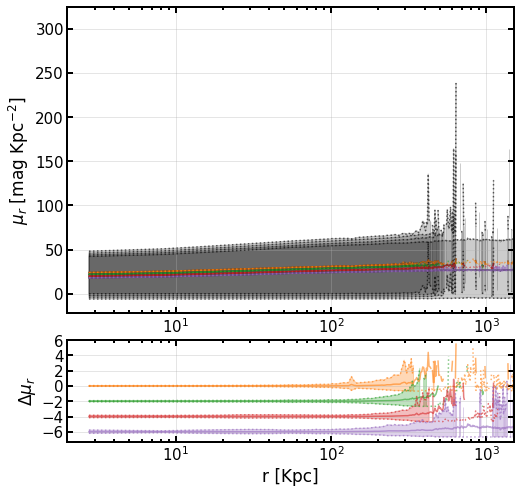

In [10]:
from matplotlib import gridspec
fig = plt.figure(figsize=(8,8))  
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C1','C2','C3','C4']
colorss = ['black','black','black','black']
lines = ['-','-','-','-']
liness = [':',':',':',':']
aa=0

for i in range(4):  
    
   
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;150)']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments%s.fits'%(flag))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
 

    up = mea+std
    low = mea-std
    
    mu = 30. - 2.5 * np.log10(mea)
    mag_unc = 2.5/np.log(10) *std/mea,
    mu_up = 30.-2.5*np.log10(mea) +mag_unc
    mu_low = 30.-2.5*np.log10(mea) -mag_unc
    
    mu_up = mu_up[0]
    mu_low = mu_low[0]
    

    

   
    plt.plot(r_red, -aa+mu, lines[i], lw=1.5,alpha=0.6,color=colorss[i],label=str_ngals[i])
    plt.plot(r_red, -aa+mu+ mu_up, liness[i], lw=1.5,alpha=0.6,color=colorss[i],label=str_ngals[i])
    plt.plot(r_red, -aa+mu- mu_low, liness[i], lw=1.5,alpha=0.6,color=colorss[i],label=str_ngals[i])
    plt.fill_between(r_red, -aa+mu + mu_up, -aa+mu - mu_low, color=colorss[i], alpha=0.2, label='')
    
    
    
    up = mea+std
    low = mea-std
    
    mag = 30 - 2.5 * np.log10(mea)
    mag_up = 30 - 2.5 *np.log10(up)
    mag_low = 30 - 2.5 * np.log10(low)
    
    plt.plot(r_red, -aa+mag, lines[i], lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.plot(r_red, -aa+mag_up, liness[i], lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.plot(r_red, -aa+mag_low, liness[i], lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, -aa+mag_up, -aa+mag_low, color=colors[i], alpha=0.4, label='')
    
    aa = aa+2
    
plt.ylabel('$\mu_{r}$ [mag Kpc$^{-2}$]', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=0)

plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
# plt.ylim(38.2,17.5)
plt.xlim(2,1500)
[ax1.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]
plt.subplots_adjust(wspace=0, hspace=0.13)

#plt.legend(bbox_to_anchor=(0.06, 0.38), loc=2, fontsize=12,borderaxespad=0.,numpoints=1,scatterpoints=1)





ax2 = plt.subplot(gs[1],sharex=ax1)
plt.xscale('log')

plt.grid(alpha=0.4)


colors = ['C1','C2','C3','C4']
aa=0

for i in range(4):  
    
   
    ngal_bins=i+1
    richness_dir = ['richness_20_30/',
                    'richness_30_45/',
                    'richness_45_60/',
                    'richness_60_beyond/']
    str_ngals = ['$\lambda$ = [20;30)',
                 '$\lambda$ = [30;45)',
                 '$\lambda$ = [45;60)',
                 '$\lambda$ = [60;150)']
    dir_sub=save_dir_rdmp+'subtracted_profiles/'+richness_dir[ngal_bins-1]
    
    dir_ind=save_dir_rdmp+'redmapper_y1_jacknife_sub_profiles/'+richness_dir[ngal_bins-1]
    jacknife_profile=np.loadtxt(dir_ind+'sub_moments%s.fits'%(flag))
    r_red, mea, std = jacknife_profile.T[0], jacknife_profile.T[1], jacknife_profile.T[2]
 
    up = mea+std
    low = mea-std

    mag = 30. - 2.5 * np.log10(mea)
    mag_up = 30. - 2.5 *np.log10(up)
    mag_low = 30. - 2.5 * np.log10(low)


    ##########################
    ## computing luptitudes ##
    ##########################

    flux = mea
    sigma_ = std

    m0 = 30.
    f0 = 10.**(m0/2.5)

    a =  2.5*np.log10(np.e) #1.08574
    sigma = sigma_/f0
    b = np.sqrt(a)*sigma
    b_ = f0 * b

    x = flux/f0 

    #mu = -a * (np.arcsinh(x/(2.*b)) + np.log(b))
    #mu = (m0 - 2.5 * np.log10(b_)) - a * np.arcsinh(flux/ (2.*b_) )  
    mu0 = (m0 - 2.5 * np.log10(b_)) - a * np.arcsinh(0./ (2.*b_) ) 
    mu = mu0 - a * np.arcsinh(flux/ (2.*b_) ) 

    var_mag_unc = ( (a)**2 * (sigma_)**2 ) / ( 4*(b_)**2 + (flux)**2) 
    mag_unc = np.sqrt( var_mag_unc )

    plt.plot(r_red, -aa+mag - mu, lines[i], lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.fill_between(r_red, -aa+mag_up - (mu + mag_unc), -aa+mag_low - (mu - mag_unc), color=colors[i], 
                     alpha=0.3, label='')
    plt.plot(r_red, -aa+mag_up - (mu + mag_unc), liness[i], lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    plt.plot(r_red, -aa+mag_low - (mu - mag_unc), liness[i], lw=1.5,alpha=0.6,color=colors[i],label=str_ngals[i])
    aa = aa+2

plt.ylabel('$\Delta\mu_{r}$', fontsize=17)
plt.xlabel('r [Kpc]', fontsize=17)

plt.xticks(fontsize = 0)
plt.tick_params(direction='in',which='major', length=6, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.tick_params(direction='in',which='minor', length=3, width=2, labelsize=0.,
               bottom='on', top='on', left='on', right ='on')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#plt.ylim(38.2,23)
plt.xlim(2,1500)
[ax2.spines[axis].set_linewidth(2.) for axis in ['top','bottom','left','right']]

#plt.legend(bbox_to_anchor=(0.06, 0.38), loc=2, fontsize=12,borderaxespad=0.,numpoints=1,scatterpoints=1)



plt.show()
##############################################################################

# for testing

In [11]:
sloan = Table.read('/home/hillysson/Downloads/fluxesnmags_ogando.fit')
fluxsloan = sloan['modelFlux_g']
sigmasloan_ = 1/np.sqrt(sloan['modelFluxIvar_g'])

m0 = 22.5
f0 = 10.**(m0/2.5)

a =  2.5*np.log10(np.e) #1.08574
sigmasloan = sigmasloan_/f0
bsloan = np.sqrt(a)*sigmasloan
bsloan_ = f0 * bsloan

x = fluxsloan/f0 

mag = 22.5-2.5 * np.log10(fluxsloan)
magsloan = sloan['modelMag_g']

mu1 = -a * (np.arcsinh(x/(2.*bsloan)) + np.log(bsloan))
mu2 = (m0 - 2.5 * np.log10(bsloan_)) - a * np.arcsinh(fluxsloan/ (2.*bsloan_) ) 
mu0 = (m0 - 2.5 * np.log10(bsloan_)) - a * np.arcsinh(0./ (2.*bsloan_) ) 
mu3 = mu0 - a * np.arcsinh(fluxsloan/ (2.*bsloan_) ) 

var = (a**(2) * sigmasloan_**(2)) / (4*bsloan_**(2) + fluxsloan**(2))
unc = np.sqrt(var)

print(' flux -- usual magnitudes -- lup magnitudes')
[print(fluxsloan[i] ,'---', mag[i], magsloan[i], '---', mu1[i], mu2[i], mu3[i]) for i in range(5)]

 flux -- usual magnitudes -- lup magnitudes
1.718216 --- 21.912306 21.909338 --- 21.904627 21.904629 21.904629
0.21727602 --- 24.15747 24.006395 --- 23.790102 23.790106 23.790106
0.0044564293 --- 28.377533 25.087517 --- 23.746231 23.746233 23.746233
0.79740846 --- 22.745798 22.732224 --- 22.336458 22.33646 22.33646
2.8859076 --- 21.349295 21.34824 --- 21.333673 21.333675 21.333675


/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


[None, None, None, None, None]

In [12]:
sloan = Table.read('/home/hillysson/Downloads/fluxesnmags_ogando.fit')
fluxsloan = sloan['modelFlux_g']
sigmasloan_ = 1/np.sqrt(sloan['modelFluxIvar_g'])

m0 = 22.5
f0 = 10.**(m0/2.5)

a =  2.5*np.log10(np.e) #1.08574
sigmasloan = sigmasloan_/f0
bsloan = np.sqrt(a)*sigmasloan
bsloan_ = f0 * bsloan

x = fluxsloan/f0 

mag = 22.5-2.5 * np.log10(fluxsloan)
magsloan = sloan['modelMag_g']

mu0 = (m0 - 2.5 * np.log10(bsloan_)) - a * np.arcsinh(0./ (2.*bsloan_) ) 
mu3 = mu0 - a * np.arcsinh(fluxsloan/ (2.*bsloan_) ) 

var = (a**(2) * sigmasloan_**(2)) / (4*bsloan_**(2) + fluxsloan**(2))
unc = np.sqrt(var)

print('flux -- lup magnitudes -- std')
[print(fluxsloan[i] ,'---', mu3[i],'---', unc[i]) for i in range(5)]

/home/hillysson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


flux -- lup magnitudes -- std
1.718216 --- 21.904629 --- 0.08685237
0.21727602 --- 23.790106 --- 0.4337596
0.0044564293 --- 23.746233 --- 0.5209803
0.79740846 --- 22.33646 --- 0.44439107
2.8859076 --- 21.333675 --- 0.12277648


[None, None, None, None, None]

In [13]:
# using x = flux * f0, b = 1.042*sigma and mu = -a * (np.arcsinh(x/(2*b_)) + np.log(b_))
# using x = flux * f0, b = 1.2*10**(-10)*10*(22.5/2.5) and mu = -a * (np.arcsinh(x/(2*b_)) + np.log(b_))

In [14]:
sloan.colnames

['objID',
 'modelFlux_g',
 'modelFlux_r',
 'modelFluxIvar_g',
 'modelFluxIvar_r',
 'modelMag_g',
 'modelMag_r',
 'modelMagErr_g',
 'modelMagErr_r']